In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict,  StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import lightgbm as lgb
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from bayes_opt import BayesianOptimization


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
#lettura csv
filepath = r"C:\Users\lucap\OneDrive\Desktop\PhD\Paper SDS\Walden 97-19 integrated v2.csv"
df = pd.read_csv(filepath, sep = ";" )
#df = df[df['m_anno_indagine'] > 2016] #seleziono le righe che riguardano l'osservatorio dal 2019 in poi
df = df[df['m_anno_indagine']>=2017].drop_duplicates(subset='IDU', keep="last")
df = df[
   df.columns[ df.isna().sum() <= 0.3 * len(df) ] ]#seleziono solo le colonne hanno valori Nan inferiori al 30%
# Rimuovere gli spazi bianchi da tutte le colonne
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

le = LabelEncoder()
df['m_sesso'] = le.fit_transform(df['m_sesso'])
df['m_p_pubblico_privato'] = le.fit_transform(df['m_p_pubblico_privato'])
df['m_p_nascita_in_italia_genitori'] = le.fit_transform(df['m_p_nascita_in_italia_genitori'])

C:\Users\lucap\AppData\Local\Temp\ipykernel_5668\1101075947.py:3: DtypeWarning: Columns (0,4,8,9,10,11,12,13,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,44,45,46,47,49,50,51,52,53,54,55,61,62,63,64,65,66,68,69,70,71,78,80,82,84,85,86,87,91,93,94,96,97,98,99,101,102,103,105,106,108,109,110,111,113,114,115,117,118,119,120,121,123,124,125,126,128,129,130,132,133,134,136,137,138,139,140,142,143,144,145,146,147,148,150,151,153,154,155,157,158,159,162,164,165,166,167,169,170,171,172,173,174,175,176,177,178,179,180,181,182,184,185,186,187,188,189,190,191,192,194,195,196,197,198,199,200,201,202,203,204,205,207,209,211,212,213,214,215,217,218,219,221,222,223,224,225,226,227,228,229,230,231,232,233,235,236,239,240,242,243,245,246,248,249,250,251,252,253,254,255,256,257,258,261,263,264,265,266,267,272,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,300,301,302,303,305,306,307,309,310,311,312,313,314,316,317,318,320,321,3

In [4]:
df.head()

,IDU,m_anno_indagine,m_modalita_telefono_vs_online,m_sesso,m_p_data_nascita,m_p_r_eta,m_p_eta_6,m_p_autocol,m_p_scolarita,m_p_pubblico_privato,m_p_r_ampiezza6,m_p_comune_istat,m_istat_reg,m_p_zona_5istat,m_p_in_ita_dal,m_p_origini,m_p_nascita_in_italia_genitori,m_p_cittadinanza,m_p_frequenza_cinema,m_p_frequenza_teatro,m_p_frequenza_concerti,m_p_frequenza_mostre,m_p_frequenza_palestra_sport,m_p_radio_ore,m_p_lettura_quotidiani,m_ac_valore_attuale_patria,m_op_unita_nazionale,m_ac_privilegio_lavoratori_sett_pubblico,m_ac_propensioneRischio_italia_vs_europa,m_ac_importanza_partiti,m_ac_diminuzione_ruolo_partiti,m_ac_affidamento_pubblica_tecnici,m_ac_valori_resistenza_altra_epoca,m_op_costituzione.1,m_ac_sindacato_ancoraUtile,m_op_miglioramento_rapp_stato_cittadini,m_ac_uguaglianza_sociale_frena_individui,m_ac_troppo_focus_uguaglianza_vs_merito,m_ac_meglio_uguaglianza_vs_merito_singolo,m_op_disorientamento_veros_realta_quotidiana,m_op_disorientamento_realta_quotidiana_vs_3anniFa,m_ac_vantaggi_globalizz_economie_mercati,m_ac_globaliz_inarrestabile,m_ac_dovere_difesa_produzPaese_vs_globaliz,m_ac_aumento_competizione_con_piuPreparati,m_ac_aumento_stress_competizione,m_ac_percez_inadeguatezza_da_velocitaCambiamento,m_op_ventennio,m_op_attitudine_italiani_fascismo,m_op_criminalita_ultimiAnni_doveVive,m_ac_nonSicuro_doveVive,m_ac_repressione_unicaArma_vs_crimin,m_ac_crimin_diventera_incontenibile,m_op_situazEconomic_propria_ultimi10anni,m_op_situazEconomic_futura,m_op_come_reddito_consenteDiVivere,m_op_legge_aborto_1987,m_op_cambio_legge_aborto,m_ac_validita_insegnamChiesa,m_op_favore_eutanasia_a_determinate_condizioni,m_ac_societa_troppoPermissiva_gay,m_ac_legalizz_drogheLeggere,m_ac_chiesa_nonDovrebbe_condizionare_stato.1,m_ac_testamento_biologico,m_ac_immigrati_rubano_lavoro,m_ac_immigrati_risorsa,m_ac_immigrati_portano_criminalita,m_ac_immigrati_devono_adeguarsi,m_ac_immigrati_diritto_voto,m_ac_immigrati_nonRispettano_regoleDelloStareInsieme,m_op_tensioneSociale_italianiVSextracom_propriaCitta,m_op_organizzazioneEuropa_futuro,m_op_sentimento_italianoVSeuropeo,m_op_importanza_essereItaliano,m_ac_modernizzazioneItalia_grazie_UE,m_op_fiducia_in_sindacati,m_p_iscrizione_sindacato,m_ac_giovani di 30anniFa miglioriDiOggi,m_ac_giovaniOggi_incapaci_fareSacrifici,m_ac_nuoveGenerazioni_miglioreranno_mondo,m_ac_impegnoSocialeGiovani_sempreMenoForte,m_ac_governatori_scegliere_senzaBadareOpposizione,m_ac_mediazione_nonRisolve_problemi,m_ac_ricercaCompromesso_faMarcire_situazioni,m_ac_religioneIslamica_pericoloPerTutti,m_ac_musulmaniInItalia_dirittoReligione_inScuole,m_ac_italia_troppeConcessioni_immigratiMusulmani,m_ac_generazioniFuture_vivrannoPeggio,m_modernizz_vs_regress_Paese,m_ac_passato_vivereMeglio_ancheSePiuPoveri,m_ac_italia_paeseInDeclino,m_op_partecipazione_in_UE,m_ac_scienza_problemi_piuChe_benefici,m_ac_scoperte_scientificTecnol_rendono_vita_piuFacile,m_ac_troppo_allarmismo_ecologia_inquinamento,m_ac_sviluppoEconomico_incompatibileCon_tutelaAmbiente,m_ac_preoccupazione_situazioneAmbientale_luogoInCuiVivo,m_op_contributoDelSingolo_salvaguardia_ambiente,m_op_impegnoPersone_in_tutelaAmbiente,m_op_attenzione_personeNelTerritorio_verso_risparmioEnergetico,m_op_attenzione_personeNelTerritorio_verso_ricicloRaccoltaDiff,m_op_attenzione_personeNelTerritorio_verso_sistemiEnergieAlternative,m_op_attenzione_personeNelTerritorio_verso_acquaistoProdottiEcosostenibili,m_op_attenzione_personeNelTerritorio_verso_impegnoTutelaAmbienteNatura,m_op_attenzione_personeNelTerritorio_verso_controlloQualitaProvenienzaAlimenti,m_ac_sacrificioEconomico_per_migliorare_ScuolaUniversitaRicerca,m_ac_ScuolaEFormazione_principaleProblema_delPaese,m_op_sistemaScolasticoItaliano,m_op_scuolaPubblica_ultimiAnni,m_ac_scuola_deveEssere_severa_selettiva_meritocratica,m_ac_valorizzare_scuoleEccellenza,m_ac_difesa_scuolaPubblica_insensata,m_ac_attuale_classeInsegnante_incompetente,m_op_reazione_a_discussioni_politiche,m_ac_sperimentazioniGenetiche_piuRischi_cheVantaggi,m_ac_

In [14]:
df[df['m_p_r_eta'] > 84]

,IDU,m_anno_indagine,m_modalita_telefono_vs_online,m_sesso,m_p_data_nascita,m_p_r_eta,m_p_eta_6,m_p_autocol,m_p_scolarita,m_p_pubblico_privato,m_p_r_ampiezza6,m_p_comune_istat,m_istat_reg,m_p_zona_5istat,m_p_in_ita_dal,m_p_origini,m_p_nascita_in_italia_genitori,m_p_cittadinanza,m_p_frequenza_cinema,m_p_frequenza_teatro,m_p_frequenza_concerti,m_p_frequenza_mostre,m_p_frequenza_palestra_sport,m_p_radio_ore,m_p_lettura_quotidiani,m_ac_valore_attuale_patria,m_op_unita_nazionale,m_ac_privilegio_lavoratori_sett_pubblico,m_ac_propensioneRischio_italia_vs_europa,m_ac_importanza_partiti,m_ac_diminuzione_ruolo_partiti,m_ac_affidamento_pubblica_tecnici,m_ac_valori_resistenza_altra_epoca,m_op_costituzione.1,m_ac_sindacato_ancoraUtile,m_op_miglioramento_rapp_stato_cittadini,m_ac_uguaglianza_sociale_frena_individui,m_ac_troppo_focus_uguaglianza_vs_merito,m_ac_meglio_uguaglianza_vs_merito_singolo,m_op_disorientamento_veros_realta_quotidiana,m_op_disorientamento_realta_quotidiana_vs_3anniFa,m_ac_vantaggi_globalizz_economie_mercati,m_ac_globaliz_inarrestabile,m_ac_dovere_difesa_produzPaese_vs_globaliz,m_ac_aumento_competizione_con_piuPreparati,m_ac_aumento_stress_competizione,m_ac_percez_inadeguatezza_da_velocitaCambiamento,m_op_ventennio,m_op_attitudine_italiani_fascismo,m_op_criminalita_ultimiAnni_doveVive,m_ac_nonSicuro_doveVive,m_ac_repressione_unicaArma_vs_crimin,m_ac_crimin_diventera_incontenibile,m_op_situazEconomic_propria_ultimi10anni,m_op_situazEconomic_futura,m_op_come_reddito_consenteDiVivere,m_op_legge_aborto_1987,m_op_cambio_legge_aborto,m_ac_validita_insegnamChiesa,m_op_favore_eutanasia_a_determinate_condizioni,m_ac_societa_troppoPermissiva_gay,m_ac_legalizz_drogheLeggere,m_ac_chiesa_nonDovrebbe_condizionare_stato.1,m_ac_testamento_biologico,m_ac_immigrati_rubano_lavoro,m_ac_immigrati_risorsa,m_ac_immigrati_portano_criminalita,m_ac_immigrati_devono_adeguarsi,m_ac_immigrati_diritto_voto,m_ac_immigrati_nonRispettano_regoleDelloStareInsieme,m_op_tensioneSociale_italianiVSextracom_propriaCitta,m_op_organizzazioneEuropa_futuro,m_op_sentimento_italianoVSeuropeo,m_op_importanza_essereItaliano,m_ac_modernizzazioneItalia_grazie_UE,m_op_fiducia_in_sindacati,m_p_iscrizione_sindacato,m_ac_giovani di 30anniFa miglioriDiOggi,m_ac_giovaniOggi_incapaci_fareSacrifici,m_ac_nuoveGenerazioni_miglioreranno_mondo,m_ac_impegnoSocialeGiovani_sempreMenoForte,m_ac_governatori_scegliere_senzaBadareOpposizione,m_ac_mediazione_nonRisolve_problemi,m_ac_ricercaCompromesso_faMarcire_situazioni,m_ac_religioneIslamica_pericoloPerTutti,m_ac_musulmaniInItalia_dirittoReligione_inScuole,m_ac_italia_troppeConcessioni_immigratiMusulmani,m_ac_generazioniFuture_vivrannoPeggio,m_modernizz_vs_regress_Paese,m_ac_passato_vivereMeglio_ancheSePiuPoveri,m_ac_italia_paeseInDeclino,m_op_partecipazione_in_UE,m_ac_scienza_problemi_piuChe_benefici,m_ac_scoperte_scientificTecnol_rendono_vita_piuFacile,m_ac_troppo_allarmismo_ecologia_inquinamento,m_ac_sviluppoEconomico_incompatibileCon_tutelaAmbiente,m_ac_preoccupazione_situazioneAmbientale_luogoInCuiVivo,m_op_contributoDelSingolo_salvaguardia_ambiente,m_op_impegnoPersone_in_tutelaAmbiente,m_op_attenzione_personeNelTerritorio_verso_risparmioEnergetico,m_op_attenzione_personeNelTerritorio_verso_ricicloRaccoltaDiff,m_op_attenzione_personeNelTerritorio_verso_sistemiEnergieAlternative,m_op_attenzione_personeNelTerritorio_verso_acquaistoProdottiEcosostenibili,m_op_attenzione_personeNelTerritorio_verso_impegnoTutelaAmbienteNatura,m_op_attenzione_personeNelTerritorio_verso_controlloQualitaProvenienzaAlimenti,m_ac_sacrificioEconomico_per_migliorare_ScuolaUniversitaRicerca,m_ac_ScuolaEFormazione_principaleProblema_delPaese,m_op_sistemaScolasticoItaliano,m_op_scuolaPubblica_ultimiAnni,m_ac_scuola_deveEssere_severa_selettiva_meritocratica,m_ac_valorizzare_scuoleEccellenza,m_ac_difesa_scuolaPubblica_insensata,m_ac_attuale_classeInsegnante_incompetente,m_op_reazione_a_discussioni_politiche,m_ac_sperimentazioniGenetiche_piuRischi_cheVantaggi,m_ac_

In [8]:
round(df['m_sesso'].value_counts(normalize=True),3)

m_sesso
0    0.501
1    0.499
Name: proportion, dtype: float64

In [9]:
round(df['m_p_eta_6'].value_counts(normalize=True),3)

m_p_eta_6
piu' di 64 anni    0.216
45-54 anni         0.200
35-44 anni         0.189
55-64 anni         0.165
25-34 anni         0.151
15-24 anni         0.078
Name: proportion, dtype: float64

In [10]:
round(df['m_p_scolarita'].value_counts(normalize=True),3)

m_p_scolarita
diploma di maturita` (5 anni)                           0.384
laurea specialistica di II livello o laurea 4-5 anni    0.188
universita` in corso/nessuna laurea conseguita          0.091
media inferiore                                         0.084
diploma di istituto professionale (3 anni)              0.071
laurea triennale di I livello                           0.059
master/scuola di specializzazione post laurea           0.052
diploma universitario/laurea breve                      0.029
dottorato di ricerca                                    0.017
elementare/privo di titolo                              0.014
superiori in corso                                      0.011
Name: proportion, dtype: float64

In [17]:
df['m_p_scolarita'].value_counts(normalize=True)

m_p_scolarita
diploma di maturita` (5 anni)                           0.383659
laurea specialistica di II livello o laurea 4-5 anni    0.188277
universita` in corso/nessuna laurea conseguita          0.090586
media inferiore                                         0.083703
diploma di istituto professionale (3 anni)              0.070826
laurea triennale di I livello                           0.059281
master/scuola di specializzazione post laurea           0.052398
diploma universitario/laurea breve                      0.028863
dottorato di ricerca                                    0.017096
elementare/privo di titolo                              0.013988
superiori in corso                                      0.011323
Name: proportion, dtype: float64

In [16]:
0.017+0.029+0.052+0.059

0.157

In [11]:
round(df['m_p_zona_5istat'].value_counts(normalize=True),3)

m_p_zona_5istat
Nord-Ovest    0.270
Sud           0.225
Nord-Est      0.200
Centro        0.193
Isole         0.111
Name: proportion, dtype: float64

In [4]:
varsToDrop = ['IDU','m_anno_indagine','m_pesos','m_peso',"m_p_cittadinanza", "m_p_data_nascita", "m_modalita_telefono_vs_online",
    'm_p_comune_istat',
                'm_p_data_nascita','m_p_eta_6',
                    'm_p_in_ita_dal','m_p_origini',
                            'm_sr_professione','m_sr_statusSocioEconomico_ceto',"m_p_autocol"
                            ] # rimuovo regioni perchè uso one hot e non voglio aumentare troppo il numero di colonne
df= df.drop(varsToDrop, axis=1)


# # Demografiche
# varsToDrop = ['IDU','m_anno_indagine','m_pesos','m_peso',"m_p_cittadinanza", "m_p_data_nascita", "m_modalita_telefono_vs_online",
#     'm_p_frequenza_cinema','m_p_frequenza_teatro','m_p_frequenza_concerti',
#         'm_p_frequenza_mostre','m_p_frequenza_palestra_sport',
#             'm_modernizz_vs_regress_Paese',
#                 'm_fiducia_proprieIdee_rispetto_avvenimentiMondo','m_p_comune_istat',
#                 'm_p_data_nascita','m_p_eta_6',\
#                     'm_p_in_ita_dal','m_p_origini',
#                         'm_p_radio_ore','m_p_lettura_quotidiani','m_p_iscrizione_sindacato',
#                             'm_sr_professione','m_sr_statusSocioEconomico_ceto',"m_p_autocol"
#                               ,"m_istat_reg"] # rimuovo regioni perchè uso one hot e non voglio aumentare troppo il numero di colonne

In [5]:
diz_aliases_ac = {"del tutto d'accordo":2,
            "del tutto<BR>d'accordo":2,
		     "d'accordo":1,
		     "ne' d'accordo ne' in disaccordo (NON STIMOLARE)":0,
             "ne d'accordo ne' in disaccordo":0,
             "ne' d'accordo ne' in disaccordo":0,
             "preferisco non rispondere":0,
             "preferisco<BR>non<BR> rispondere":0,
            "non saprei":0,
             "in disaccordo":-1,
             'del tutto in disaccordo':-2,
             "del tutto disaccordo":-2,
             "del tutto<BR>in disaccordo":-2,
             
            
}

nomi_var = df.columns.tolist()
for var in nomi_var:
    if '_ac_' in var:
        df[var] = df[var].replace(diz_aliases_ac)
        
        
diz_aliases_op = {"molto":2,
            "poco":-1,
            "pocao":-1,
		     "abbastanza":1,
		     "non saprei":0,
            "nessuno":-2,
            "per niente":-2}

nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'op' in var:
        df[var] = df[var].replace(diz_aliases_op)
        

diz_aliases_trend = {"in trend":1,
                 "slight in trend":1,
                 "slight off trend":0,
                 "off trend":0,
                 'non classificati':0}
 
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'TREND' in var:
        df[var] = df[var].replace(diz_aliases_trend)
        
        
diz_aliases_scol = {"elementare/privo di titolo":1,
                 "media inferiore":1,
                 "diploma di maturita` (5 anni)":2,
                 "superiori in corso":2,
                 'diploma di istituto professionale (3 anni)':2,
                 'universita` in corso/nessuna laurea conseguita':4,
                 'laurea triennale di I livello':4,
                 'diploma universitario/laurea breve':4,
                 'laurea specialistica di II livello o laurea 4-5 anni':4,
                 'master/scuola di specializzazione post laurea':4,
                 'dottorato di ricerca':4
                 }
 
df['m_p_scolarita'] = df['m_p_scolarita'].replace(diz_aliases_scol)



diz_aliases_geo = {'meno di 5.000':1,
                 'da 5.001 a 10.000':1,
                 'da 10.001 a 30.000':2,
                 'da 30.001 a 100.000':2,
                 'da 100.001 a 250.000':3,
                 'piu` di 250.001':3
                 }
 
df['m_p_r_ampiezza6'] = df['m_p_r_ampiezza6'].replace(diz_aliases_geo)

diz_aliases_eco = {
                 "mi sento povero e non arrivo mai a fine mese":-1,
                 "avverto difficolta'":-1,
                 "arrivo a fine mese con molte difficolta'":-1,
                 "con tranquillita'":1,
                 'agiatamente':1
                 }
 
df['m_op_come_reddito_consenteDiVivere'] = df['m_op_come_reddito_consenteDiVivere'].replace(diz_aliases_eco)


df = pd.get_dummies(df, columns=['m_op_preferenza_lavorativa'], prefix='prf_lav',dtype=int)

#df = pd.get_dummies(df, columns=['m_p_zona_5istat'], prefix='zona')
df = pd.get_dummies(df, columns=['m_istat_reg'], prefix='reg',dtype=int)

diz_aliases_quot = {
                 0:0,
                 'preferisco non rispondere':0,
                 "si alcune volte alla settimana":1,
                 "si ogni giorno":1
                 }
 
df['m_p_lettura_quotidiani'] = df['m_p_lettura_quotidiani'].replace(diz_aliases_quot)

diz_aliases_freq_y = {'mai':0,
                     "piu' raramente":0,
                 "alcune volte l'anno":1,
                  "piu' volte alla settimana":2,
                 'mensile':1,
                 'settimanale':2}
 
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'm_p_' in var:
        df[var] = df[var].replace(diz_aliases_freq_y)
        
        
diz_aliases_freq = {'non saprei':0,
                     "non ascolto la radio":0,
                 "da piu' di un'ora fino a due ore":1,
                  "da piu' di tre ore fino a quattro ore":2,
                 'oltre quattro':2,
                 "da piu' di due ore fino a tre ore":2,
                 "meno di un'ora":1}
 
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'm_p_' in var:
        df[var] = df[var].replace(diz_aliases_freq)
        

diz_aliases_comp = {
                 0:0,
                 'inferiore':-1,
                 'uguale':0,
                 "maggiore":1,
                 'nan':0
                 }
 
df['m_op_disorientamento_realta_quotidiana_vs_3anniFa'] = df['m_op_disorientamento_realta_quotidiana_vs_3anniFa'].replace(diz_aliases_comp)


diz_aliases_situazEconomic = {
    'rimasta la stessa': 0,
    'peggiorata': -1,
    'non sa/non risponde': 0,
    'nan': 0,
    'migliorata': 1
}
df['m_op_situazEconomic_propria_ultimi10anni'] = df['m_op_situazEconomic_propria_ultimi10anni'].replace(diz_aliases_situazEconomic)


diz_aliases_futEconomic = {
    'peggiorare': -1,
    'rimanere la stessa': 0,
    'non sa/non risponde': 0,
    'nan': 0,
    'migliorare': 1
}
df['m_op_situazEconomic_futura'] = df['m_op_situazEconomic_futura'].replace(diz_aliases_futEconomic)


diz_aliases_abo = {
    'una cattiva legge': -1,
    'una legge buona ma che va cambiata': 1,
    'una buona legge': 1,
    'non saprei/preferisco non rispondere': 0,
    'nan': 0
}

df['m_op_legge_aborto_1987'] = df['m_op_legge_aborto_1987'].replace(diz_aliases_abo)


diz_aliases_eut = {
    'no': -1,
    'si': 2,
    'non sa/non risponde': 0,
    'dipende dalle condizioni':1
}

df['m_op_favore_eutanasia_a_determinate_condizioni'] = df['m_op_favore_eutanasia_a_determinate_condizioni'].replace(diz_aliases_eut)


diz_aliases_identita = {
    "piu' europeo che italiano": 2,
    'sia italiano che europeo': 1,
    'solo italiano': -2,
    "piu' italiano che europeo": -1,
    'non sa - non risponde': 0,
    'solo europeo': 2,
    'nan': 0
}
df['m_op_sentimento_italianoVSeuropeo'] = df['m_op_sentimento_italianoVSeuropeo'].replace(diz_aliases_identita)


diz_aliases_modernizzazione = {
    'si sta modernizzando': 1,
    'sta regredendo': -1,
    'non sa/non risponde': 0,
    'nan': 0
}
df['m_modernizz_vs_regress_Paese'] = df['m_modernizz_vs_regress_Paese'].replace(diz_aliases_modernizzazione)


diz_aliases_vantaggi = {
    "piu' vantaggi": 1,
    'vantaggi e svantaggi in egual misura': 0,
    "piu' svantaggi": -1,
    "ne' vantaggi ne' svantaggi": 0,
    'non sa/non risponde': 0,
    'nan': None
}
df['m_op_partecipazione_in_UE'] = df['m_op_partecipazione_in_UE'].replace(diz_aliases_vantaggi)


diz_aliases_livello = {
    'bassa': -1,
    'media': 1,
    'alta': 2,
    0: 0,
    'nan': None
}
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'm_op_attenzione_' in var:
        df[var] = df[var].replace(diz_aliases_livello)
        
        
diz_aliases_andamento = {
    'rimasta uguale': 0,
    'peggiorata': -1,
    'migliorata': 1,
    0: 0,
    'nan': None
}
df['m_op_scuolaPubblica_ultimiAnni'] = df['m_op_scuolaPubblica_ultimiAnni'].replace(diz_aliases_andamento)


diz_aliases_quantita = {
    1: 1,
    'poca&nbsp;': -1,
    'molta': 2,
    'nessuna': -2,
    0: 0,
    'nan': None
}
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'm_op_fiducia_' in var:
        df[var] = df[var].replace(diz_aliases_quantita)
        
        
diz_aliases_postoStabile = {
    "d'accordo": 1,
    'in disaccordo': -1,
    "del tutto d'accordo": 2,
    'del tutto in disaccordo': -2,
    'preferisco non rispondere': 0,
    'nan': None
}
df['m_op_rinuncie_per_postoStabile'] = df['m_op_rinuncie_per_postoStabile'].replace(diz_aliases_postoStabile)


diz_aliases_pop = {
    'molti danni': 2,
    'nessun danno': 0,
    'qualche danno': 1,
    0: 0,
    'nan': None
}
df['m_op_danni_populismo_in_italia'] = df['m_op_danni_populismo_in_italia'].replace(diz_aliases_pop)

varsToDrop_val = ["m_op_unita_nazionale", 'm_op_costituzione.1','m_op_miglioramento_rapp_stato_cittadini','m_op_ventennio',
'm_op_criminalita_ultimiAnni_doveVive','m_op_cambio_legge_aborto','m_op_organizzazioneEuropa_futuro', 'm_op_fiducia_in_sindacati','m_p_iscrizione_sindacato'
,'m_op_tensioneSociale_italianiVSextracom_propriaCitta','m_op_sistemaScolasticoItaliano','m_op_reazione_a_discussioni_politiche',
'm_op_fiducia_negli_altri','m_op_inclusione_societa','m_op_margineIntervento_vita','m_op_paure_della_vecchiaia','m_fiducia_proprieIdee_rispetto_avvenimentiMondo'
,'m_op_origine_maggiorImpulso_ripresa_italia', 'm_op_profilo_socioCulturale_vs_genitori','m_op_causePrincipali_violenzaDonne_1','m_op_causePrincipali_violenzaDonne_2',
'm_op_circostanze_cheGiustificano_violenzaMoglie','m_op_priorita_per_affrontare_violenzaDonne_1','m_op_priorita_per_affrontare_violenzaDonne_2', 'm_TREND_15_FASCISMO NEW',
'm_op_quanto_populista_PD','m_op_quanto_populista_M5S','m_op_quanto_populista_Lega','m_op_quanto_populista_FI','m_op_definizione_populismo',
'm_op_caratteristiche_dei_politici_apprezzati','m_op_cosa_contradistingue_comunita','m_op_pericoliEdisagi_figli_cheSpaventano_genitori_04',
'm_op_pericoliEdisagi_figli_cheSpaventano_genitori_03','m_op_pericoliEdisagi_figli_cheSpaventano_genitori_02','m_op_pericoliEdisagi_figli_cheSpaventano_genitori_01',
'm_op_definizione_bene_comune','m_op_comunita_appartenenza_01','m_p_zona_5istat','m_op_rimanere_in_propriaZona_vs_spostarsi',
'm_ac_preparazione_nuoveGenerazioni_piuScadente','m_op_attualita_concetti_sinistraCentroDestra','m_op_importanza_essereItaliano',
'm_op_attitudine_italiani_fascismo']
df= df.drop(varsToDrop_val, axis=1)

In [6]:
df.shape

(4504, 188)

In [7]:
df.isnull().sum()

m_sesso                                                                                                0
m_p_r_eta                                                                                              0
m_p_scolarita                                                                                          0
m_p_pubblico_privato                                                                                   0
m_p_r_ampiezza6                                                                                        0
m_p_nascita_in_italia_genitori                                                                         0
m_p_frequenza_cinema                                                                                   0
m_p_frequenza_teatro                                                                                   0
m_p_frequenza_concerti                                                                                 0
m_p_frequenza_mostre                                   

In [8]:
diz_aliases_int_voto = {"Partito Democratico-PD":'Sx/CSx',
                "Partito Democratico":'Sx/CSx',
                "Lega con Salvini":'Dx/CDx',
                "Lega Nord":'Dx/CDx',
                "Lega":'Dx/CDx',
                "Forza Italia":'Dx/CDx',
                "Fratelli d'Italia":"Dx/CDx",
                'MoVimento 5 Stelle':'M5S',
                'Movimento 5 stelle':'M5S',
                'voterei  scheda bianca / annullerei la scheda':'astensione/indecisi',
                'voterei scheda bianca / scheda nulla':'astensione/indecisi',
                "+Europa":'Sx/CSx',
                "piu' Europa con Emma Bonino": "Sx/CSx",
                'Sinistra italiana (SEL + altri)':'Sx/CSx',
                'Potere al Popolo':'Sx/CSx',
                'Rifondazione Comunista':'Sx/CSx',
                "Fratelli d'Italia-Alleanza Nazionale&nbsp;":"Dx/CDx",
                'La Sinistra':'Sx/CSx',
                'Verdi':'Sx/CSx',
                'non andrei a votare':'astensione/indecisi',
                'sono indeciso' : 'astensione/indecisi',
                'Liberi e Uguali' : 'Sx/CSx',
                'Italia dei Valori' : 'Sx/CSx',
                'Scelta Civica&nbsp;' : 'Sx/CSx',
                'Italia Unica di Corrado Passera' : 'Sx/CSx',
                "Noi con l'Italia UDC&nbsp;" : 'Dx/CDx',
                "altro partito di area di governo (SVP, Centro Democratico....)" : 'Altro partito',
                "Nuovo Centro Destra con UDC e PPI" : 'Altro partito'
                }

In [11]:
diz_aliases_int_voto_astenuti = {"Partito Democratico-PD":'Voter',
                "Partito Democratico":'Voter',
                "Lega con Salvini":'Voter',
                "Lega Nord":'Voter',
                "Lega":'Voter',
                "Forza Italia":'Voter',
                "Fratelli d'Italia":"Voter",
                'MoVimento 5 Stelle':'Voter',
                'Movimento 5 stelle':'Voter',
                'voterei  scheda bianca / annullerei la scheda':'Abstained or Undecided',
                'voterei scheda bianca / scheda nulla':'Abstained or Undecided',
                "+Europa":'Voter',
                "piu' Europa con Emma Bonino": "Voter",
                'Sinistra italiana (SEL + altri)':'Voter',
                'Potere al Popolo':'Voter',
                'Rifondazione Comunista':'Voter',
                "Fratelli d'Italia-Alleanza Nazionale&nbsp;":"Voter",
                'La Sinistra':'Voter',
                'Verdi':'Voter',
                'non andrei a votare':'Abstained or Undecided',
                'sono indeciso' : 'Abstained or Undecided',
                'Liberi e Uguali' : 'Voter',
                'Italia dei Valori' : 'Voter',
                'Scelta Civica&nbsp;' : 'Voter',
                'Italia Unica di Corrado Passera' : 'Voter',
                "Noi con l'Italia UDC&nbsp;" : 'Voter',
                "altro partito di area di governo (SVP, Centro Democratico....)" : 'Voter',
                "Nuovo Centro Destra con UDC e PPI" : 'Voter',
                "preferisco non rispondere" : 'Abstained or Undecided'
                }

In [12]:
df['m_p_int_voto'] = df['m_p_int_voto'].replace(diz_aliases_int_voto_astenuti)
df['m_p_int_voto'].value_counts()

m_p_int_voto
Voter                     3323
Abstained or Undecided    1119
Altro partito               62
Name: count, dtype: int64

In [13]:
#df = df[~df['m_p_int_voto'].isin(['Altro partito', 'preferisco non rispondere', 'indecisi','astensione/indecisi' ])]
df = df[~df['m_p_int_voto'].isin(['Altro partito'])]

In [14]:
df['m_p_int_voto'].value_counts()

m_p_int_voto
Voter                     3323
Abstained or Undecided    1119
Name: count, dtype: int64

In [15]:
df = df.fillna(0)

In [16]:
df.shape

(4442, 188)

In [17]:
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('à', 'a')

In [18]:
df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '').str.replace(' ', '_')
df.columns = df.columns.str.replace('[()\']+|,\s*', '', regex=True)

In [19]:
df.head()

,m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_privato,m_p_r_ampiezza6,m_p_nascita_in_italia_genitori,m_p_frequenza_cinema,m_p_frequenza_teatro,m_p_frequenza_concerti,m_p_frequenza_mostre,m_p_frequenza_palestra_sport,m_p_radio_ore,m_p_lettura_quotidiani,m_ac_valore_attuale_patria,m_ac_privilegio_lavoratori_sett_pubblico,m_ac_propensioneRischio_italia_vs_europa,m_ac_importanza_partiti,m_ac_diminuzione_ruolo_partiti,m_ac_affidamento_pubblica_tecnici,m_ac_valori_resistenza_altra_epoca,m_ac_sindacato_ancoraUtile,m_ac_uguaglianza_sociale_frena_individui,m_ac_troppo_focus_uguaglianza_vs_merito,m_ac_meglio_uguaglianza_vs_merito_singolo,m_op_disorientamento_veros_realta_quotidiana,m_op_disorientamento_realta_quotidiana_vs_3anniFa,m_ac_vantaggi_globalizz_economie_mercati,m_ac_globaliz_inarrestabile,m_ac_dovere_difesa_produzPaese_vs_globaliz,m_ac_aumento_competizione_con_piuPreparati,m_ac_aumento_stress_competizione,m_ac_percez_inadeguatezza_da_velocitaCambiamento,m_ac_nonSicuro_doveVive,m_ac_repressione_unicaArma_vs_crimin,m_ac_crimin_diventera_incontenibile,m_op_situazEconomic_propria_ultimi10anni,m_op_situazEconomic_futura,m_op_come_reddito_consenteDiVivere,m_op_legge_aborto_1987,m_ac_validita_insegnamChiesa,m_op_favore_eutanasia_a_determinate_condizioni,m_ac_societa_troppoPermissiva_gay,m_ac_legalizz_drogheLeggere,m_ac_chiesa_nonDovrebbe_condizionare_stato.1,m_ac_testamento_biologico,m_ac_immigrati_rubano_lavoro,m_ac_immigrati_risorsa,m_ac_immigrati_portano_criminalita,m_ac_immigrati_devono_adeguarsi,m_ac_immigrati_diritto_voto,m_ac_immigrati_nonRispettano_regoleDelloStareInsieme,m_op_sentimento_italianoVSeuropeo,m_ac_modernizzazioneItalia_grazie_UE,m_ac_giovani_di_30anniFa_miglioriDiOggi,m_ac_giovaniOggi_incapaci_fareSacrifici,m_ac_nuoveGenerazioni_miglioreranno_mondo,m_ac_impegnoSocialeGiovani_sempreMenoForte,m_ac_governatori_scegliere_senzaBadareOpposizione,m_ac_mediazione_nonRisolve_problemi,m_ac_ricercaCompromesso_faMarcire_situazioni,m_ac_religioneIslamica_pericoloPerTutti,m_ac_musulmaniInItalia_dirittoReligione_inScuole,m_ac_italia_troppeConcessioni_immigratiMusulmani,m_ac_generazioniFuture_vivrannoPeggio,m_modernizz_vs_regress_Paese,m_ac_passato_vivereMeglio_ancheSePiuPoveri,m_ac_italia_paeseInDeclino,m_op_partecipazione_in_UE,m_ac_scienza_problemi_piuChe_benefici,m_ac_scoperte_scientificTecnol_rendono_vita_piuFacile,m_ac_troppo_allarmismo_ecologia_inquinamento,m_ac_sviluppoEconomico_incompatibileCon_tutelaAmbiente,m_ac_preoccupazione_situazioneAmbientale_luogoInCuiVivo,m_op_contributoDelSingolo_salvaguardia_ambiente,m_op_impegnoPersone_in_tutelaAmbiente,m_op_attenzione_personeNelTerritorio_verso_risparmioEnergetico,m_op_attenzione_personeNelTerritorio_verso_ricicloRaccoltaDiff,m_op_attenzione_personeNelTerritorio_verso_sistemiEnergieAlternative,m_op_attenzione_personeNelTerritorio_verso_acquaistoProdottiEcosostenibili,m_op_attenzione_personeNelTerritorio_verso_impegnoTutelaAmbienteNatura,m_op_attenzione_personeNelTerritorio_verso_controlloQualitaProvenienzaAlimenti,m_ac_sacrificioEconomico_per_migliorare_ScuolaUniversitaRicerca,m_ac_ScuolaEFormazione_principaleProblema_delPaese,m_op_scuolaPubblica_ultimiAnni,m_ac_scuola_deveEssere_severa_selettiva_meritocratica,m_ac_valorizzare_scuoleEccellenza,m_ac_difesa_scuolaPubblica_insensata,m_ac_attuale_classeInsegnante_incompetente,m_ac_sperimentazioniGenetiche_piuRischi_cheVantaggi,m_ac_problemi_eticiMorali_sperimentazioneGenetica,m_ac_nord_unicoMotore_economiaItaliana,m_ac_lavoroNord_consente_diEssere_alPasso_con_UE,m_ac_guerre_talvolta_maleNecessario.1,m_ac_italia_ipartecipazioneIn_missioniMilitariEstere,m_ac_lavorare_importante_postoStabile_no,m_op_rinuncie_per_postoStabile,m_ac_badare_propriInteressi_perSopravvivere,m_ac_sentirsiSpesso_solo_isolato,m_ac_modelloImprenditorialePrivato_unico_produceRicchezzaPerTutti,m_ac_modelloImprenditorialePrivato_unico_meritocratico,m_ac_modelloImprenditorialePrivato_unico_garantireEquita,m_ac_italia_riparte_solo_puntandoSu_cittaEterritori_noSt

Classificatore

In [20]:
# provo a rimuovere le righe con i valori Nan poiché solo 285
df = df.dropna()

In [21]:
df.shape

(4442, 188)

In [22]:
X = df.drop(columns = ['m_p_int_voto'])
y = df.m_p_int_voto

In [23]:
# Assuming y contains your string labels
label = ['Voter', 'Abstained or Undecided']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform y
y_encoded = label_encoder.fit_transform(y)

# Now y_encoded contains integer labels
print("Valori numerici delle etichette:")
print(y_encoded)

# Conoscere la corrispondenza tra le etichette originali e i nuovi valori numerici
print("Corrispondenza tra etichette originali e nuovi valori numerici:")
for label, value in zip(y, y_encoded):
    print(f"{label} --> {value}")


Valori numerici delle etichette:
[1 1 0 ... 0 1 1]
Corrispondenza tra etichette originali e nuovi valori numerici:
Voter --> 1
Voter --> 1
Abstained or Undecided --> 0
Voter --> 1
Voter --> 1
Abstained or Undecided --> 0
Voter --> 1
Voter --> 1
Abstained or Undecided --> 0
Abstained or Undecided --> 0
Abstained or Undecided --> 0
Voter --> 1
Abstained or Undecided --> 0
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Abstained or Undecided --> 0
Voter --> 1
Abstained or Undecided --> 0
Voter --> 1
Abstained or Undecided --> 0
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Abstained or Undecided --> 0
Abstained or Undecided --> 0
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Abstained or Undecided --> 0
Abstained or Undecided --> 0
Abstained or Undecided --> 0
Voter --> 1
Abstained or Undecided --> 0
Voter --> 1
Abstained or Undecided --> 0
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Voter --> 1
Abstained or 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state = 42, stratify=y)

In [28]:
# Definisci la strategia di cross-validation con 10 fold stratificati
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definisci lo spazio degli iperparametri
param_space = {
    'learning_rate': Real(0.01, 0.5, 'log-uniform'),
    'num_leaves': Integer(2, 100),
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(1, 20),
    'colsample_bytree': Real(0.1, 1.0, 'uniform'),
    'reg_alpha': Real(0.0, 1.0, 'uniform'),
    'reg_lambda': Real(0.0, 5.0, 'uniform')
}

# Inizializza il classificatore LightGBM
lgb_classifier = lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split', random_state=42)

# Inizializza la ricerca bayesiana
opt = BayesSearchCV(
    lgb_classifier,
    search_spaces=param_space,
    n_iter=50, # Numero di iterazioni della ricerca bayesiana
    cv=cv_strategy, # Utilizza la strategia di cross-validation definita
    n_jobs=4,
    random_state=42,
    scoring='roc_auc'  # Ottimizza per AUC
)

# Esegui la ricerca bayesiana
opt.fit(X_train, y_train)

# Stampa i parametri migliori trovati
print("Migliori parametri:", opt.best_params_)



[LightGBM] [Info] Number of positive: 2824, number of negative: 951
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 3775, number of used features: 185
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748079 -> initscore=1.088396
[LightGBM] [Info] Start training from score 1.088396
Migliori parametri: OrderedDict([('colsample_bytree', 0.1), ('learning_rate', 0.046099392843374866), ('max_depth', 13), ('n_estimators', 200), ('num_leaves', 62), ('reg_alpha', 0.0), ('reg_lambda', 5.0)])


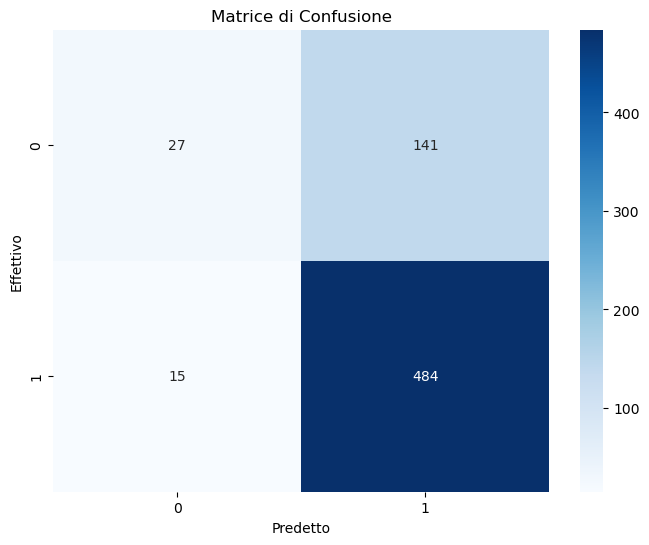

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.16      0.26       168
           1       0.77      0.97      0.86       499

    accuracy                           0.77       667
   macro avg       0.71      0.57      0.56       667
weighted avg       0.74      0.77      0.71       667



In [29]:
# Fai previsioni sul set di test
y_pred_lgb = opt.predict(X_test)

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred_lgb)


# Visualizza la matrice di confusione utilizzando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice di Confusione")
plt.xlabel("Predetto")
plt.ylabel("Effettivo")
plt.show()

# Visualizza il classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))

In [30]:
# Calcola le metriche totali
accuracy = accuracy_score(y_test, y_pred_lgb)
precision = precision_score(y_test, y_pred_lgb, average='weighted')
recall = recall_score(y_test, y_pred_lgb, average='weighted')
f1 = f1_score(y_test, y_pred_lgb, average='weighted')

# Stampa le metriche totali
print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))

Accuracy: 0.77
Precision: 0.74
Recall: 0.77
F1 Score: 0.71


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.668     | 0.4371    | 4.754     | 0.3687    | 13.18     | 2.404     | 73.4      | 0.6232    |
| 2         | 0.6669    | 0.8796    | 3.006     | 0.357     | 3.35      | 9.729     | 174.9     | 0.6849    |
| 3         | 0.6794    | 0.2636    | 0.917     | 0.1591    | 11.92     | 4.888     | 93.68     | 0.8447    |
| 4         | 0.6877    | 0.2255    | 1.461     | 0.1895    | 10.75     | 8.067     | 79.95     | 0.8057    |
| 5         | 0.6839    | 0.6332    | 0.2323    | 0.3077    | 5.899     | 1.585     | 192.3     | 0.9863    |
| 6         | 0.685     | 0.8276    | 1.523     | 0.05786   | 14.63     | 4.961     | 68.31     | 0.7981    |
| 7         | 0.6733    | 0.1309    | 4.547     | 0.1368    | 14.26     | 3.805     | 128.0     | 0.8187    |
| 8       

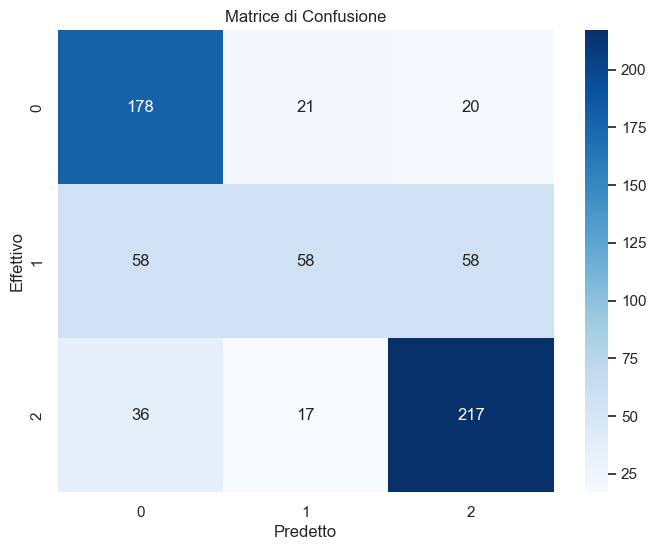

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.73       219
           1       0.60      0.33      0.43       174
           2       0.74      0.80      0.77       270

    accuracy                           0.68       663
   macro avg       0.66      0.65      0.64       663
weighted avg       0.67      0.68      0.67       663



In [142]:
# Funzione di ottimizzazione
def xgb_evaluate(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'multi:softprob',
        'num_class': 3,  # Modifica secondo il numero delle tue classi
        'n_jobs': 4,
        'random_state': 42
    }
    
    xgb_model = xgb.XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(xgb_model, X_train, y_train, scoring='accuracy', cv=cv)
    return scores.mean()

# Definire il dominio di ricerca
pbounds = {
    'max_depth': (3, 20),
    'learning_rate': (0.01, 0.5),
    'n_estimators': (50, 200),
    'gamma': (0, 5),
    'min_child_weight': (1, 10),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.1, 1.0)
}


# Ottimizzazione bayesiana
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=10, n_iter=50)

# Migliori parametri
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# Addestrare il modello con i migliori parametri
best_xgb = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    num_class=3,  # Modifica secondo il numero delle tue classi
    n_jobs=4,
    random_state=42
)

best_xgb.fit(X_train, y_train)

# Fare previsioni sul set di test
y_pred = best_xgb.predict(X_test)

# Calcolare la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Visualizzare la matrice di confusione utilizzando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice di Confusione")
plt.xlabel("Predetto")
plt.ylabel("Effettivo")
plt.show()

# Visualizzare il classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [146]:
# Calcola le metriche totali
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Stampa le metriche totali
print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))

Accuracy: 0.68
Precision: 0.67
Recall: 0.68
F1 Score: 0.67


In [147]:
# Visualizza l'importanza delle feature
importances = miglior_modello.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
1,m_p_r_eta,1105
93,m_ac_italia_ipartecipazioneIn_missioniMilitari...,450
43,m_ac_chiesa_nonDovrebbe_condizionare_stato.1,398
19,m_ac_valori_resistenza_altra_epoca,391
94,m_ac_lavorare_importante_postoStabile_no,366
...,...,...
167,reg_Abruzzo,0
168,reg_Basilicata,0
184,reg_Umbria,0
185,reg_Valle_Daosta,0


In [149]:
# Definisci la strategia di cross-validation con 10 fold stratificati
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definisci lo spazio degli iperparametri
param_space = {
    'learning_rate': Real(0.01, 0.5, 'log-uniform'),
    'num_leaves': Integer(2, 100),
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(1, 20),
    'colsample_bytree': Real(0.1, 1.0, 'uniform'),
    'reg_alpha': Real(0.0, 1.0, 'uniform'),
    'reg_lambda': Real(0.0, 5.0, 'uniform')
}

# Inizializza il classificatore LightGBM
lgb_classifier = lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split', random_state=42)

cross_validations = {}
df_cross_validations = pd.DataFrame()

df_X_train_full = X_train.copy()
df_X_test_full = X_test.copy()

acc_scores = {'n_features': [], 'acc_score': []}

for i in range(len(df_X_train_full.columns), 10, -1):
    rfe = RFE(lgb_classifier, n_features_to_select=i)
    rfe = rfe.fit(df_X_train_full, y_train.ravel())

    print(set(rfe.feature_names_in_).difference(rfe.get_feature_names_out()))
    X_train_transformed = rfe.transform(df_X_train_full)
    X_test_transformed = rfe.transform(df_X_test_full)
    
    df_X_train_full = pd.DataFrame(X_train_transformed, columns=rfe.get_feature_names_out())
    df_X_test_full = pd.DataFrame(X_test_transformed, columns=rfe.get_feature_names_out())

    # Inizializza la ricerca bayesiana
    opt = BayesSearchCV(
        lgb_classifier,
        search_spaces=param_space,
        n_iter=40,  # Numero di iterazioni della ricerca bayesiana
        cv=cv_strategy,  # Utilizza la strategia di cross-validation definita
        n_jobs=4,
        random_state=42
    )

    # Esegui la ricerca bayesiana
    opt.fit(df_X_train_full, y_train.ravel())

    # Salva i risultati della cross-validation
    cross_validations[i] = opt
    _tmp_cv = pd.DataFrame(opt.cv_results_)
    _tmp_cv['n_features'] = i
    _tmp_cv['features'] = ','.join([column for column in rfe.get_feature_names_out()])
    
    df_cross_validations = pd.concat([df_cross_validations, _tmp_cv], ignore_index=True)
    
    # Estrai il miglior modello e fai previsioni sul set di test
    miglior_modello = opt.best_estimator_
    miglior_modello.fit(df_X_train_full, y_train.ravel())
    y_pred = miglior_modello.predict(df_X_test_full)  
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Numero di feature: {i}, Accuratezza: {accuracy}")
    acc_scores['n_features'].append(i)
    acc_scores['acc_score'].append(accuracy)

# Visualizza i risultati
print("Risultati Cross-Validation:")
print(df_cross_validations)

# Visualizza l'accuratezza in funzione del numero di feature
plt.figure(figsize=(10, 6))
plt.plot(acc_scores['n_features'], acc_scores['acc_score'], marker='o')
plt.xlabel('Numero di Feature')
plt.ylabel('Accuratezza')
plt.title('Accuratezza in funzione del numero di feature')
plt.grid(True)
plt.show()

# Salva i risultati in un file CSV (opzionale)
df_cross_validations.to_csv('cross_validation_results.csv', index=False)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 2648, number of used features: 185
[LightGBM] [Info] Start training from score -1.107336
[LightGBM] [Info] Start training from score -1.337648
[LightGBM] [Info] Start training from score -0.898697
set()
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 2648, number of used features: 185
[LightGBM] [Info] Start training from score -1.107336
[LightGBM] [Info] Start training from score -1.337648
[LightGBM] [Info] St

KeyboardInterrupt: 

In [150]:
cross_validations = {}

df_cross_validations = pd.DataFrame()

df_X_train_full = X_train
df_X_test_full = X_test

acc_scores = {'n_features':[],'acc_score':[]}
for i in range(len(df_X_train_full.columns),10,-1):
    rfe = RFE(rf_classifier,n_features_to_select=i)
    rfe = rfe.fit(df_X_train_full, y_train.ravel())

    print(set(rfe.feature_names_in_).difference(rfe.get_feature_names_out()))
    X_train_transformed = rfe.transform(df_X_train_full)
    X_test_transformed = rfe.transform(df_X_test_full)
    
    df_X_train_full = pd.DataFrame(X_train_transformed,columns=rfe.get_feature_names_out())
    df_X_test_full = pd.DataFrame(X_test_transformed,columns=rfe.get_feature_names_out())

            
    parametri_grid_lgb = {
            'learning_rate' : [0.03368851897306291],
            'n_estimators' : [135],
            'max_depth' : [13],
            'colsample_bytree' : [0.3102745722485355],
            'reg_alpha' : [0.02354920960868235],
            'reg_lambda' : [0.01979707285897026]
            }


    grid_search = GridSearchCV(lgb_classifier, parametri_grid_lgb, cv=10,
                           scoring='accuracy',
                           return_train_score=True,n_jobs=4)
    grid_search.fit(df_X_train_full, y_train.ravel())
    cross_validations[i] = grid_search 
    _tmp_cv = pd.DataFrame(grid_search.cv_results_)
    _tmp_cv['n_features'] = i
    _tmp_cv['features'] = ','.join([column for column in rfe.get_feature_names_out() ])
    
    df_cross_validations = pd.concat([df_cross_validations,_tmp_cv])
    
    model = grid_search.best_estimator_
    model.fit(df_X_train_full,y_train.ravel())
    y_pred = model.predict(df_X_test_full)  
    accuracy = accuracy_score(y_test,y_pred)
    print(accuracy)
    acc_scores['n_features'].append(i)
    acc_scores['acc_score'].append(accuracy)
    
 

set()
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 2648, number of used features: 185
[LightGBM] [Info] Start training from score -1.107336
[LightGBM] [Info] Start training from score -1.337648
[LightGBM] [Info] Start training from score -0.898697
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [156]:
df_cross_validations.sort_values('mean_test_score',ascending=False).head(6)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score,n_features,features
0,6.363181,0.669651,0.025316,0.005098,0.310275,0.033689,13,135,0.023549,0.019797,"{'colsample_bytree': 0.3102745722485355, 'lear...",0.698113,0.709434,0.686792,0.694340,0.701887,0.713208,0.698113,0.675472,0.674242,0.670455,0.692206,0.014181,1,0.970625,0.966009,0.968947,0.966429,0.973143,0.970625,0.970206,0.970206,0.968960,0.967701,0.969285,0.002044,179,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
0,5.839954,1.426995,0.025541,0.009167,0.310275,0.033689,13,135,0.023549,0.019797,"{'colsample_bytree': 0.3102745722485355, 'lear...",0.690566,0.732075,0.679245,0.690566,0.701887,0.690566,0.698113,0.679245,0.674242,0.681818,0.691832,0.015784,1,0.968947,0.970206,0.968527,0.970206,0.972723,0.968527,0.970206,0.968527,0.971896,0.968121,0.969789,0.001478,165,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
0,5.874140,1.112533,0.028625,0.011545,0.310275,0.033689,13,135,0.023549,0.019797,"{'colsample_bytree': 0.3102745722485355, 'lear...",0.683019,0.735849,0.694340,0.683019,0.683019,0.698113,0.701887,0.698113,0.659091,0.681818,0.691827,0.018786,1,0.969786,0.968947,0.968527,0.972723,0.973982,0.970206,0.971884,0.970206,0.971477,0.971477,0.970921,0.001616,184,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
0,4.895076,1.027447,0.030477,0.010961,0.310275,0.033689,13,135,0.023549,0.019797,"{'colsample_bytree': 0.3102745722485355, 'lear...",0.694340,0.743396,0.690566,0.686792,0.690566,0.705660,0.686792,0.683019,0.659091,0.674242,0.691447,0.020900,1,0.966429,0.967268,0.969786,0.967268,0.970206,0.971465,0.970625,0.968527,0.973154,0.968121,0.969285,0.002021,156,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
0,6.001956,1.373305,0.031988,0.015321,0.310275,0.033689,13,135,0.023549,0.019797,"{'colsample_bytree': 0.3102745722485355, 'lear...",0.683019,0.754717,0.679245,0.679245,0.698113,0.709434,0.683019,0.660377,0.681818,0.681818,0.691081,0.024414,1,0.972723,0.971465,0.967268,0.969786,0.973563,0.971884,0.970625,0.969786,0.973154,0.969379,0.970963,0.001866,181,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
0,3.836839,0.942733,0.023502,0.008369,0.310275,0.033689,13,135,0.023549,0.019797,"{'colsample_bytree': 0.3102745722485355, 'lear...",0.679245,0.698113,0.694340,0.694340,0.686792,0.720755,0.709434,0.667925,0.662879,0.696970,0.691079,0.016771,1,0.943349,0.942929,0.943768,0.943349,0.941670,0.941251,0.943349,0.938733,0.944211,0.940856,0.942346,0.001606,71,"m_p_r_eta,m_ac_privilegio_lavoratori_sett_pubb..."


In [157]:
tab_res = df_cross_validations.sort_values('mean_test_score',ascending=False).head(6)
tab_res = tab_res.tail(1)
tab_res


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score,n_features,features
0,3.836839,0.942733,0.023502,0.008369,0.310275,0.033689,13,135,0.023549,0.019797,"{'colsample_bytree': 0.3102745722485355, 'lear...",0.679245,0.698113,0.69434,0.69434,0.686792,0.720755,0.709434,0.667925,0.662879,0.69697,0.691079,0.016771,1,0.943349,0.942929,0.943768,0.943349,0.94167,0.941251,0.943349,0.938733,0.944211,0.940856,0.942346,0.001606,71,"m_p_r_eta,m_ac_privilegio_lavoratori_sett_pubb..."


In [158]:
best_features_set = tab_res['features']
best_features_set = tab_res['features'].values[0]
best_features_set = best_features_set.split(',')
best_features_set

['m_p_r_eta',
 'm_ac_privilegio_lavoratori_sett_pubblico',
 'm_ac_propensioneRischio_italia_vs_europa',
 'm_ac_importanza_partiti',
 'm_ac_diminuzione_ruolo_partiti',
 'm_ac_affidamento_pubblica_tecnici',
 'm_ac_valori_resistenza_altra_epoca',
 'm_ac_sindacato_ancoraUtile',
 'm_ac_uguaglianza_sociale_frena_individui',
 'm_ac_troppo_focus_uguaglianza_vs_merito',
 'm_ac_meglio_uguaglianza_vs_merito_singolo',
 'm_op_disorientamento_veros_realta_quotidiana',
 'm_ac_vantaggi_globalizz_economie_mercati',
 'm_ac_dovere_difesa_produzPaese_vs_globaliz',
 'm_ac_nonSicuro_doveVive',
 'm_ac_repressione_unicaArma_vs_crimin',
 'm_ac_crimin_diventera_incontenibile',
 'm_ac_validita_insegnamChiesa',
 'm_ac_societa_troppoPermissiva_gay',
 'm_ac_legalizz_drogheLeggere',
 'm_ac_chiesa_nonDovrebbe_condizionare_stato.1',
 'm_ac_testamento_biologico',
 'm_ac_immigrati_rubano_lavoro',
 'm_ac_immigrati_risorsa',
 'm_ac_immigrati_portano_criminalita',
 'm_ac_immigrati_devono_adeguarsi',
 'm_ac_immigrati_diritt

In [159]:
tab_res['params'].values[0]

{'colsample_bytree': 0.3102745722485355,
 'learning_rate': 0.03368851897306291,
 'max_depth': 13,
 'n_estimators': 135,
 'reg_alpha': 0.02354920960868235,
 'reg_lambda': 0.01979707285897026}